# Exercise 07 CNN & Transfer Learning - Instruction

## Pedagogy

This notebook serves as an instruction for implementing transfer learning with pre-trained CNNs for image classificatoin tasks

Please use this notebook as a reference and guide to complete the assignment.

### Import libraries

In this notebook, we will use the following new libraries:
- `tqdm` for showing a probress bar during training and test

In [ ]:
# install tqdm
!conda install tqdm -y

In [1]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import classification_report

from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

## Instruction

In this notebook, we will build a multi-class image classifier with pre-trained CNNs and transfer learning.

The problem to be solved is to classify RGB images into one of the 10 pre-defined classes:

![](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)

## Step 1. Build the data pipeline

We will use the PyTorch built-in CIFAR-10 dataset, consists of 60,000 $32\times32$ RGB images in 10 classes, with 6,000 images per class. You can find more information about this dataset from the [PyTorch documentation](https://www.tensorflow.org/datasets/catalog/cifar10) and the [original source](https://www.cs.toronto.edu/~kriz/cifar.html).

In this step, we need to:
- Define the transformations applied to the CIFAR-10 dataset according to the requirement of pre-trained CNNs
- Load the CIFAR-10 dataset and divide it into the training, validation, and test set
- Create dataloaders for the training, validatoin, and test set
- (Optional) Display some of images in the dataset as examples

In [3]:
# define transformations required by the pre-trained SqueezeNet model
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit SqueezeNet input
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  # Normalization parameters for pre-trained models
])

To use pre-trained CNNs, we need to transform the images as required by the specific pre-trained model.

`torchvision.models` provides a list of pre-trained models for different tasks. These models are trained on huge datasets, for example, the ImageNet dataset that contains 14,197,122 images. Therefore, these pre-trained models have learned to extract different features from generic images.

When training these models, the training images are pre-processed by the following steps (you can find more information [here](https://pytorch.org/vision/stable/models/generated/torchvision.models.squeezenet1_1.html#torchvision.models.squeezenet1_1)):
- Resize to `resize_size = [256]`
- A central crop of `crop_size = [224]`
- Rescale to `[0.0, 1.0]`
- Normalize using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`

Therefore, to use these pre-trained models for transfer learning, we also need to pre-process the images by the same steps.
- The size of images in CIFAR-10 dataset is $32\times32$, the height is the same as the width, so we can directly resize the images to $224\times224$
- The images in CIFAR-10 are already scaled to `[0.0, 1.0]`, no need for rescaling
- We need to normalize the images in CIFAR-10 using the same mean and standard deviation

We can use the built-in transform functions in `torchvision.transforms` to perform these pre-processing. More specifically, we first define a sequence of transformations to perform. Then we use these transformations to pre-process the images when loading the dataset.

In [4]:
# load CIFAR-10 dataset
train_val_ds = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)
test_ds = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2]
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# create the train and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

When training large CNN models, you may not have enough RAM. If you encounter this problem, you can reduce the batch size, which will reduce the amount of memory required for computing a batch.

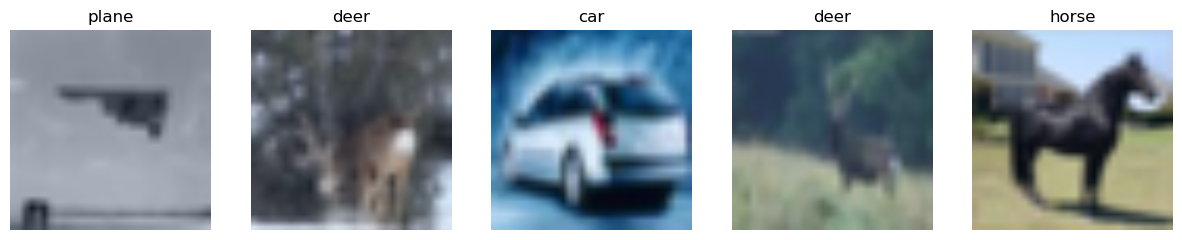

In [6]:
# define a function to display several images in the dataset
def display_dataset(dataset, n = 10,classes = None):
    fig, ax = plt.subplots(1, n, figsize = (15, 3))
    mn = min([dataset[i][0].min() for i in range(n)]) # scale the pixel values for display
    mx = max([dataset[i][0].max() for i in range(n)]) # scale the pixel values for display
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0] - mn)/(mx - mn), (1, 2, 0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])
# class names
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# display several example images
display_dataset(train_ds, n = 5, classes = classes)

## Step 2. Load Pre-trained model and Re-build the classifier

As we will use pre-trained CNNs in transfer learning, there is no need to define a custom class for the neural network.

Instead, we need to perform the following steps:
- Load the pre-trained model (pre-trained values of weight and bias parameters)
- Replace the classifier part according to the problem to solved
    - We have 10 classes in CIFAR-10 dataset, therefore the final FC layer should contains 10 neurons with linear activation function, which will output the logits
    - You can define the structure of the classifier part just like defining an ANN
- Freeze the learning parameters of the feature extractor part
    - Set the `requires_grad` attribute of each parameter to `False`
    - No gradients will be computed in both forward and backward propagation
- Set up GPU acceleration if it's available 

In [7]:
# load pre-trained SqueezeNet 1.1 model
squeezenet = models.squeezenet1_1(pretrained = True)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

We can see that the pre-trained Squeeze Net contains two parts:
- `features`: The feature extractor
- `classifier`: Use the previously extracted features for classification

To use this pre-trained model, we need to modify the `classifier` part to make it output the logits of 10 classes. We can:
- Replace the entire `classifier` part
- Modify some of the layers in this part
- Add additional layers after this part

As long as the modified `classifier` can output 10 logits, we can use this model to solve our problem. Here we replace the entire `classifier` part by defining a sequence of FC layers.

In [8]:
# replace the classifier part
squeezenet.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(1000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(10)
)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

We can see the `classifier` part is already replaced. We also need to freeze the learning parameters of the `features` part by setting the `requires_grad` attribute to `False`. Otherwise, `PyTorch` will compute the gradients automatically, even though we won't use them to update these learning parameters.

In [9]:
# freeze the learning parameters of the feature extractor part
for parameter in squeezenet.features.parameters():
    parameter.requires_grad = False

In [10]:
# set GPU acceleration
# get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
squeezenet = squeezenet.to(device)

Using mps device


## Step 3. Train the re-built classifier

Here we can use the same `train()` function as the previous session.

Since the training process will be time consuming, we can add progress bars for each epoch to when processing each training/validation batch. That's why we need the `tqdm` library.

We embed the `tqdm` progress bar in the `train()` function.

In [11]:
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss, patience_counter = np.inf, 0
    saved_path, start_time = '', datetime.datetime.now()
    histories = {'train_batch': [], 'train_epoch': [], 'val_batch': [], 'val_epoch': []}

    for epoch in range(epochs):
        # train
        model.train()
        train_epoch_loss = 0.0
        for X, y in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            train_batch_loss = loss_fn(model(X), y)
            train_batch_loss.backward()
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
            histories['train_batch'].append(train_batch_loss.item())
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for X, y in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y = X.to(device), y.to(device)
                val_batch_loss = loss_fn(model(X), y)
                val_epoch_loss += val_batch_loss.item()
                histories['val_batch'].append(val_batch_loss.item())
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        if current_lr != optimizer.param_groups[0]['lr']:
            print(f'Learning rate reduced after epoch {epoch+1}')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss, patience_counter = val_epoch_loss, 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = end_time.strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = f'epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping!')
                break
                
    return histories, saved_path

Then we need to define the training hyper-parameters.

There is one thing different. When creating the optimizer instance, instead of optimizing the parameters of the entire netowrk, we only optimize the `classifier` part. Therefore, the feature extractor part will remain unchanged.

In [12]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    squeezenet.classifier.parameters(), # only optimize the classifier part
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
)

In [13]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    squeezenet,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
squeezenet.load_state_dict(torch.load(saved_path))

Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.78it/s]


Epoch 1: train loss = 1.125907, val loss = 0.776844, time consumed = 0:00:38
Model saved after epoch 1


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.70it/s]


Epoch 2: train loss = 0.899970, val loss = 0.653701, time consumed = 0:01:17
Model saved after epoch 2


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.64it/s]


Epoch 3: train loss = 0.781844, val loss = 0.560230, time consumed = 0:01:58
Model saved after epoch 3


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Epoch 4: train loss = 0.686884, val loss = 0.580492, time consumed = 0:02:38


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.70it/s]


Epoch 5: train loss = 0.661546, val loss = 0.555444, time consumed = 0:03:17
Model saved after epoch 5


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Epoch 6: train loss = 0.670319, val loss = 0.559111, time consumed = 0:03:57


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.69it/s]


Epoch 7: train loss = 0.670466, val loss = 0.577792, time consumed = 0:04:37


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


Epoch 8: train loss = 0.668641, val loss = 0.546337, time consumed = 0:05:17
Model saved after epoch 8


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch 9: train loss = 0.684561, val loss = 0.590505, time consumed = 0:05:58


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.60it/s]


Epoch 10: train loss = 0.699579, val loss = 0.639578, time consumed = 0:06:38


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 11: train loss = 0.695124, val loss = 0.553503, time consumed = 0:07:19
Learning rate reduced after epoch 11


Validation batch: 100%|█████████████████████████| 20/20 [00:09<00:00,  2.12it/s]


Epoch 12: train loss = 0.469107, val loss = 0.421596, time consumed = 0:08:06
Model saved after epoch 12


Validation batch: 100%|█████████████████████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch 13: train loss = 0.300861, val loss = 0.421386, time consumed = 0:09:18
Model saved after epoch 13


Validation batch: 100%|█████████████████████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 14: train loss = 0.244922, val loss = 0.439453, time consumed = 0:10:24


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.52it/s]


Epoch 15: train loss = 0.242704, val loss = 0.466962, time consumed = 0:11:10


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.64it/s]


Epoch 16: train loss = 0.238339, val loss = 0.465363, time consumed = 0:11:52
Learning rate reduced after epoch 16


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Epoch 17: train loss = 0.162841, val loss = 0.435413, time consumed = 0:12:32


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.68it/s]

Epoch 18: train loss = 0.118376, val loss = 0.435927, time consumed = 0:13:11
Early stopping!


<All keys matched successfully>

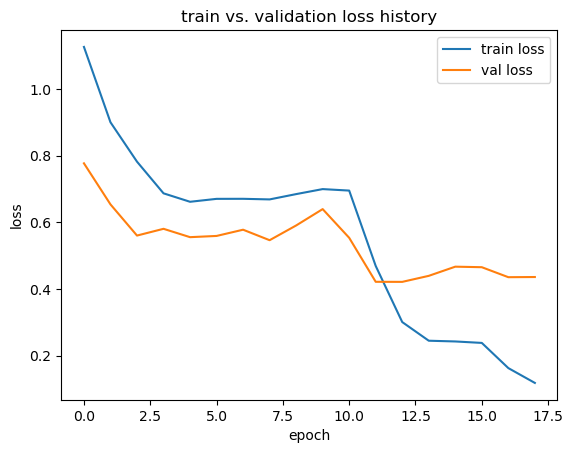

In [14]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Step 4. Test and evaluation

We also add `tqdm` progress bar in the `test()` function.

We can now check the effectiveness of transfer learning.

If you already finish the assignment of session 6, you can compare the classification accuracy of this Squeeze Net-based model with you hand-crafted CNN to see which one is better.

In [15]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in tqdm(dataloader, desc = f'Test batch'):
            X, y = X.to(device), y.to(device)
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [16]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, squeezenet, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred, target_names = classes))

Test batch: 100%|███████████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


test loss = 0.44598556905984876
              precision    recall  f1-score   support

       plane       0.85      0.90      0.87      1000
         car       0.92      0.92      0.92      1000
        bird       0.80      0.85      0.82      1000
         cat       0.73      0.72      0.72      1000
        deer       0.80      0.85      0.83      1000
         dog       0.80      0.76      0.78      1000
        frog       0.89      0.90      0.89      1000
       horse       0.93      0.83      0.88      1000
        ship       0.91      0.92      0.91      1000
       truck       0.93      0.91      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The predicted class is: deer
The predicted probability is: 0.99288744


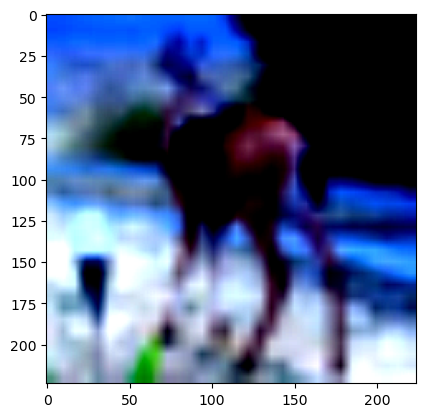

In [17]:
# display an example
plt.imshow(test_ds[100][0].numpy().transpose(1, 2, 0))
print('The predicted class is:', classes[test_pred[100]])
print('The predicted probability is:', test_prob[100, test_pred[100]])

## Optional Step. Fine-tuning entire CNN

If you are not satisfactory of the performance, or you want to fully release the potential of the pre-trained model, you can try to re-train not only the `classifier` part, but the entire pre-trained model.

Warning: This can be very time-consuming!

To do this, the common practice is:
1. Load the pre-trained model
2. Replace the `classifer`, freeze the `feature extractor`
3. Train the replaced `classifier` part with a relative large learning rate
4. Unfreeze the `feature extractor`
5. Fine-tune the entire netowrk (both the `feature extractor` and the `classifier`) with a relative small learning rate

We already finished the first three steps. Now let's do the following steps.

To unfreeze the `feature extractor` part, simply set `requires_grad` to `True`.

In [18]:
# unfreeze the learning parameters of the feature extractor part
for parameter in squeezenet.features.parameters():
    parameter.requires_grad = True

When creating the optimizer, specify optimizing the entire network.

In [19]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-5 # a relative small learning rate
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    squeezenet.parameters(), # optimize the entire network, not only the classifier part
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
)

Warning: This can be very time-consuming!

Better to do this using Google Colab if you don't have the GPU accelation on your computer.

If you encounter the out-of-memory problem, reduce the batch size.

In [20]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    squeezenet,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
squeezenet.load_state_dict(torch.load(saved_path))

Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.56it/s]


Epoch 1: train loss = 0.198400, val loss = 0.395412, time consumed = 0:01:03
Model saved after epoch 1


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch 2: train loss = 0.189309, val loss = 0.388525, time consumed = 0:02:07
Model saved after epoch 2


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.64it/s]


Epoch 3: train loss = 0.179640, val loss = 0.382757, time consumed = 0:03:11
Model saved after epoch 3


Validation batch: 100%|█████████████████████████| 20/20 [00:08<00:00,  2.34it/s]


Epoch 4: train loss = 0.174036, val loss = 0.379745, time consumed = 0:04:28
Model saved after epoch 4


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.57it/s]


Epoch 5: train loss = 0.171394, val loss = 0.377185, time consumed = 0:05:54
Model saved after epoch 5


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 6: train loss = 0.165977, val loss = 0.370692, time consumed = 0:07:08
Model saved after epoch 6


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch 7: train loss = 0.162248, val loss = 0.372544, time consumed = 0:08:15


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 8: train loss = 0.159914, val loss = 0.369816, time consumed = 0:09:20
Model saved after epoch 8


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.65it/s]


Epoch 9: train loss = 0.161167, val loss = 0.373728, time consumed = 0:10:23


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.64it/s]


Epoch 10: train loss = 0.159743, val loss = 0.368000, time consumed = 0:11:27
Model saved after epoch 10


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch 11: train loss = 0.156628, val loss = 0.368153, time consumed = 0:12:30


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 12: train loss = 0.152029, val loss = 0.368263, time consumed = 0:13:33


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 13: train loss = 0.150208, val loss = 0.366853, time consumed = 0:14:37
Model saved after epoch 13


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.65it/s]


Epoch 14: train loss = 0.146919, val loss = 0.365928, time consumed = 0:15:41
Model saved after epoch 14


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


Epoch 15: train loss = 0.146196, val loss = 0.366097, time consumed = 0:16:44


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.67it/s]


Epoch 16: train loss = 0.144498, val loss = 0.364363, time consumed = 0:17:47
Model saved after epoch 16


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Epoch 17: train loss = 0.142908, val loss = 0.364011, time consumed = 0:18:50
Model saved after epoch 17


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.65it/s]


Epoch 18: train loss = 0.138416, val loss = 0.364756, time consumed = 0:19:54


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.70it/s]


Epoch 19: train loss = 0.137049, val loss = 0.361928, time consumed = 0:20:58
Model saved after epoch 19


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 20: train loss = 0.136860, val loss = 0.364125, time consumed = 0:22:04


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.65it/s]


Epoch 21: train loss = 0.133404, val loss = 0.361036, time consumed = 0:23:09
Model saved after epoch 21


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.57it/s]


Epoch 22: train loss = 0.133075, val loss = 0.362258, time consumed = 0:24:14


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 23: train loss = 0.133567, val loss = 0.364965, time consumed = 0:25:18


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 24: train loss = 0.125619, val loss = 0.359839, time consumed = 0:26:22
Model saved after epoch 24


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.60it/s]


Epoch 25: train loss = 0.130765, val loss = 0.361215, time consumed = 0:27:27


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.59it/s]


Epoch 26: train loss = 0.125831, val loss = 0.357887, time consumed = 0:28:31
Model saved after epoch 26


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.59it/s]


Epoch 27: train loss = 0.122616, val loss = 0.358323, time consumed = 0:29:35


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 28: train loss = 0.122992, val loss = 0.363734, time consumed = 0:30:39


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.58it/s]


Epoch 29: train loss = 0.124600, val loss = 0.357077, time consumed = 0:31:42
Model saved after epoch 29


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.59it/s]


Epoch 30: train loss = 0.120126, val loss = 0.361646, time consumed = 0:32:47


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.57it/s]


Epoch 31: train loss = 0.117672, val loss = 0.357100, time consumed = 0:33:51


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.58it/s]


Epoch 32: train loss = 0.117788, val loss = 0.360468, time consumed = 0:34:54
Learning rate reduced after epoch 32


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.56it/s]


Epoch 33: train loss = 0.115910, val loss = 0.357461, time consumed = 0:35:59


Validation batch: 100%|█████████████████████████| 20/20 [00:07<00:00,  2.58it/s]

Epoch 34: train loss = 0.117328, val loss = 0.359153, time consumed = 0:37:03
Early stopping!


<All keys matched successfully>

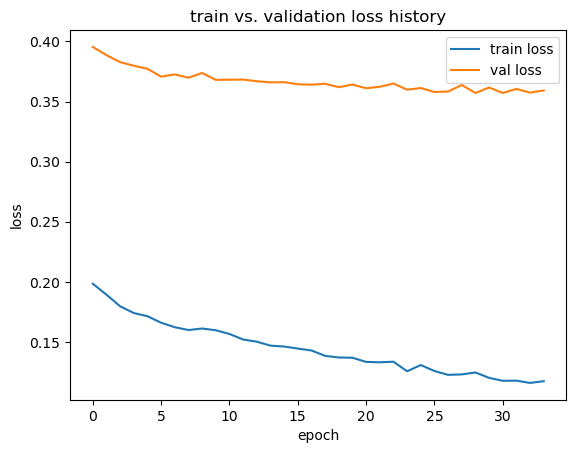

In [21]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, squeezenet, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred, target_names = classes))

Test batch: 100%|███████████████████████████████| 20/20 [00:07<00:00,  2.54it/s]


test loss = 0.3818166255950928
              precision    recall  f1-score   support

       plane       0.88      0.91      0.89      1000
         car       0.93      0.93      0.93      1000
        bird       0.86      0.84      0.85      1000
         cat       0.76      0.77      0.77      1000
        deer       0.86      0.87      0.86      1000
         dog       0.82      0.81      0.82      1000
        frog       0.90      0.91      0.91      1000
       horse       0.91      0.89      0.90      1000
        ship       0.93      0.93      0.93      1000
       truck       0.93      0.92      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



We can see after fine-tuning, the accuracy increased from 0.85 to 0.88.

The improvement is not very sigfinicant, so most of the time we don't need to fine-tune the entire network.